

# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



In [1]:
# your code
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

fig = plt.figure()

for i in range(10):
    im_idx = np.argwhere(y == str(i))[0]
    plottable_image = np.reshape(X[im_idx], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7)

ValueError: Length of values (1) does not match length of index (70000)

<Figure size 432x288 with 0 Axes>

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
The Bayes rule states that the posterior holds
$$
\Pr(y|x)=\frac{\Pr(x|y)\Pr(y)}{\Pr(x)}
$$
Since $\Pr(x)$ is constant, it holds that

$$
\text{Posterior}=\Pr(y|x)\propto \Pr(x|y)\Pr(y) = \text{Likelihood}\cdot\text{Prior}
$$

So we can only estimate the right hand side, and take the $\arg\!\max$ as our classification. That is,

$$
h(x) = \arg\!\max_j\,\pi_j P_j(x)
$$

Also, due to the independence assumption, the joint probability becomes the product, so
$$
P_j(x) = P_{j}(x_1, \ldots, x_{784}) = \prod_{i=1}^{784} P_{ji}(x_i) = \prod_{i=1}^{784} p_{ji}^{x_i} (1-p_{ji})^{1-x_i}
$$

Finally, in order to avoid underflow it is better to look at the log, that is
$$
h(x) = \arg\!\max_j\,\pi_j P_j(x) = \arg\!\max_j\,\log(\pi_j P_j(x)) = \arg\!\max_j\,\log \pi_j + \sum_{i=1}^{784} \left(x_i \log p_{ji} +  (1-x_i) \log (1-p_{ji})\right)
$$


In order to esimate the different parameters in the above decision rule, we can choose the Bayesian best estimators simply as
$$
\begin{align}
\hat{\pi}_j &= \frac{n_j}{n} = \frac{\text{number of samples of class $j$}}{\text{total number of samples}} \\
\hat{p}_{ji} &= \frac{n_{ji}}{n_j} = \frac{\text{number of class $j$ samples where $x_i=1$}}{\text{number of samples of class $j$}} \\
\end{align}
$$

**Bonus part**

However, what if for some class $n_{ji} = 0$ or $n_{ji}=n_j$? In order to combat such edge cases which will set the probability of some $x_i$ being white (1) to 0 or 1 for that class, we can use something like "Laplace smoothing" and set

$$
\hat{p}_{ji} = \frac{n_{ji}+1}{n_j+2}
$$

which is like we added 2 additional samples for class $j$, one with $x_i=0$ and one with $x_i=1$. This can also be interpreted as a uniform prior on $p_{ji}$ with 1 pseudo count of each event.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2

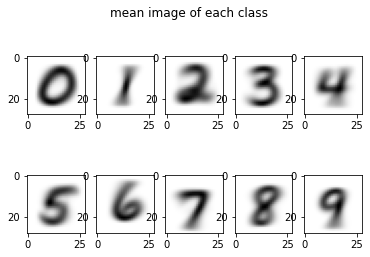

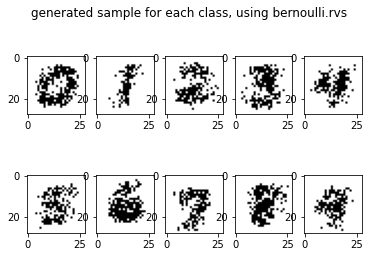

In [ ]:
# code goes here
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import bernoulli

# plot mean image of each class
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_estimate = clf.predict(X_train)
fig = plt.figure()
plt.suptitle("mean image of each class")
for i in range(10):
    im_idx = np.argwhere(y_estimate == str(i))
    plottable_image = np.reshape(np.mean(X_train[im_idx],axis=0), (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

# generate a sample for each class    
probs = (np.exp(1) ** clf.feature_log_prob_) > 0.5 #* 255
probs = bernoulli.rvs(np.exp(1) ** clf.feature_log_prob_)
fig = plt.figure()
plt.suptitle("generated sample for each class, using bernoulli.rvs")
for i in range(10):
    plottable_image = np.reshape(probs[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')  

Text(0.5, 1.0, 'Accuracy Score: 0.8283')

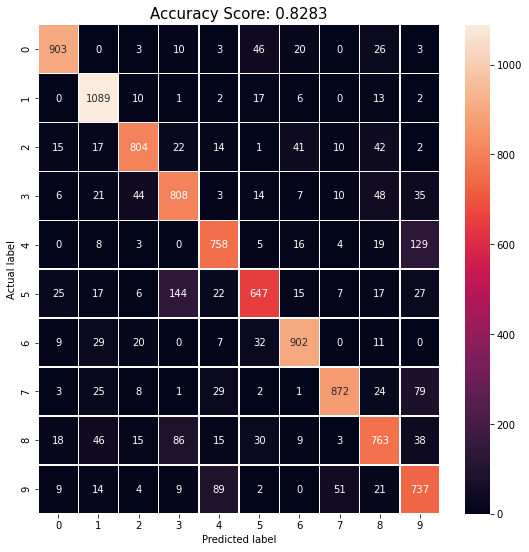

In [ ]:
# Confusion matrix and accuracy score

from sklearn import metrics
import seaborn as sns

predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

As can be seen, altough the mean image for each class looks pretty good, the generated samples are nothing like real handwritten digits. This is due to the low complexity of the model (assuming both independence and binarization of the pixels).

The total accuracy was found to be 0.83, which is pretty good considering how simplified this model is. The confusion matrix plotted below shows that while the there is a relative high accuracy for each class, there are quite a few miss classifications, where the highest error (confusion) occurs for the digits pair 3 and 5, the pair 4 and 9, and to somewhat less extent also the pair 3 and 8 (note that the confusion is **not symmetric**).

One way to find the optimal threshold for binarization, is to divide the trainning set into train and validation sets (maybe using k-fold cross validation), estimate the accuracy for different threshold values, and evaluate which would be the best threshold based on the resulting accuracy. Although there are also works on generalizin the ROC curve for multiclass problems (for example, see: [A simplified extension of the Area under the ROC to the multiclass domain](http://homepage.tudelft.nl/a9p19/papers/prasa_06_vuc.pdf), and [R pROC package](https://cran.r-project.org/web/packages/pROC/pROC.pdf)), the ROC curve won't be too helpful in this case, as the binarization threshold does not set the point on the TPR-FPR balance directly. 

Regardless, there are better approaches in image processing for image binarization, but this is another scope completely.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

In [ ]:
# implement Naive Bayes estimator

from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix
import numpy as np
class NaiveBayes(BaseEstimator, ClassifierMixin):
  def fit(self, x, y):
    self.V = x.shape[1]
    n_d = x.shape[0]
    self.n_c = y.max() + 1
    prior = np.bincount(y)/n_d
    self.log_prior = np.log(prior)
    pct = np.zeros((self.n_c, self.V))
    #pct = csr_matrix((self.n_c, self.V))
    for c in range(self.n_c):
      ic = y==c
      xc = x[ic]
      Tct = xc.sum(axis=0)
      pct[c, :] = (Tct+1)/(Tct.sum()+self.V)
    self.log_pct = np.log(pct)
    
  def predict_log_proba(self, x):
    if not isinstance(x, np.ndarray):
      x = x.toarray()
    ll = np.dot(x, self.log_pct.T) # X(n,v) P(c,v)
    score = ll + self.log_prior
    return score      
  
  def predict(self, x):
    return np.argmax(self.predict_log_proba(x), axis=1)

In [ ]:


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# CountVectorizer to count words
count_vect = CountVectorizer(stop_words='english')

nb = NaiveBayes()

# chain the vectroizer and the model
pipe = make_pipeline(count_vect, nb)
pipe.fit(newsgroups_train.data, newsgroups_train.target)

# find accuracy over the test data
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_test = newsgroups_test.target
y_pred = pipe.predict(newsgroups_test.data)
report = classification_report(y_test, y_pred, target_names=newsgroups_test.target_names)

print("implementation accuracy over the test data:")
print(report)
print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

implementation accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
                 sci.med       

In [ ]:
# built in sklearn.naive_bayes.MultinomialNB accuracy

from sklearn.naive_bayes import MultinomialNB

sklearn_nb = MultinomialNB()
sklearn_pipe = make_pipeline(count_vect, sklearn_nb)
sklearn_pipe.fit(newsgroups_train.data, newsgroups_train.target)
sklearn_y_pred = sklearn_pipe.predict(newsgroups_test.data)
sklearn_report = classification_report(y_test, sklearn_y_pred, target_names=newsgroups_test.target_names)

print("sklearn.naive_bayes.MultinomialNB accuracy over the test data:")
print(sklearn_report)
print("accuracy: {:0.3f}".format(accuracy_score(y_test, sklearn_y_pred)))

sklearn.naive_bayes.MultinomialNB accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
            

In [ ]:
model = MultinomialNB()

from sklearn.model_selection import learning_curve
n, tr, ts = learning_curve(model, newsgroups_train.data, newsgroups_train.target, verbose=10)

[learning_curve] Training set sizes: [ 905 2941 4978 7014 9051]
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ , score=(train=0.842, test=0.435), total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................ , score=(train=0.769, test=0.540), total=   0.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ................ , score=(train=0.710, test=0.554), total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV] ................ , score=(train=0.695, test=0.555), total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


[CV] ................ , score=(train=0.677, test=0.572), total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV] ................ , score=(train=0.815, test=0.403), total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.0s remaining:    0.0s


[CV] ................ , score=(train=0.748, test=0.535), total=   0.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.3s remaining:    0.0s


[CV] ................ , score=(train=0.709, test=0.545), total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.2s remaining:    0.0s


[CV] ................ , score=(train=0.695, test=0.560), total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.7s remaining:    0.0s


[CV] ................ , score=(train=0.677, test=0.573), total=   1.9s
[CV]  ................................................................
[CV] ................ , score=(train=0.815, test=0.415), total=   0.5s
[CV]  ................................................................
[CV] ................ , score=(train=0.748, test=0.530), total=   0.8s
[CV]  ................................................................
[CV] ................ , score=(train=0.698, test=0.551), total=   1.2s
[CV]  ................................................................
[CV] ................ , score=(train=0.693, test=0.570), total=   1.6s
[CV]  ................................................................
[CV] ................ , score=(train=0.674, test=0.576), total=   1.9s
[CV]  ................................................................
[CV] ................ , score=(train=0.815, test=0.407), total=   0.8s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   47.8s finished


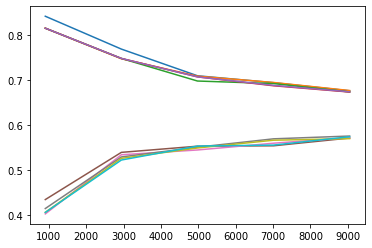

In [ ]:
plt.plot(n, tr, n, ts)


As the size of the training set increases, the training score curve and the cross-validation score curve converge. The cross-validation accuracy increases as data is added. 

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

How can you correct the analyzed error?

We can find the top contributing words for each category and check the ratio of false prediction for these words. Could be that some of them are not specific enough and should be removed from the model.